In [15]:
from manim import *
from PIL import Image
import jupyter_capture_output

video_scene = f" -v WARNING --disable_caching cf_Scene"
image_scene = f" -v WARNING --disable_caching -r {2*427},{2*240}  -s cf_Scene"

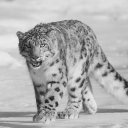

In [166]:
# reading the image
image_snow_leopard1 = Image.open('external_media/SnowLeopard1_128.jpg')
image_snow_leopard2 = Image.open('external_media/SnowLeopard2_128.jpg')

# convert image to greyscale
image_snow_leopard1_greyscale = image_snow_leopard1.convert('L')

# creating a numpy array from the greyscale picture (division of the greyscale values by 2 to fit the properties of the encoding)
image_snow_leopard1_greyscale_array = np.array(image_snow_leopard1_greyscale)


# returning an omega_xyc tupel for given image coordinates and greyscale
def get_omega_xyc(i_row, j_column, image_array):
    omega_x_encoded = j_column + 128                                                            # turns row number into the correct frequency by adding 128
    omega_y_encoded = 3*128 - i_row - 1                                                         # turns column number into its correspoding frequency
    omega_c_encoded = image_array[i_row, j_column] / 2 + 3*128                                  # calculates the greyscale value into its frequency
    return (omega_x_encoded, omega_y_encoded, omega_c_encoded)


# creating iterators with encoded values used by the animation
encoded_data_list = []
for i_row in range(128):
    for j_column in range(128):
        encoded_data_list.append(get_omega_xyc(i_row, j_column, image_snow_leopard1_greyscale_array))


# iterating through the image via spiral from outside to inside
encoded_data_list_spiral = []
track_list = []
i_row = 0
j_column = 0
row_start = 1
row_end = 128
column_start = 0
column_end = 128
while (column_start != column_end and row_start != row_end):
    while (j_column < column_end):
        encoded_data_list_spiral.append(get_omega_xyc(i_row, j_column, image_snow_leopard1_greyscale_array))
        track_list.append((i_row, j_column))
        j_column += 1
    j_column -= 1
    column_end -=1
    i_row += 1
    while (i_row < row_end):
        encoded_data_list_spiral.append(get_omega_xyc(i_row, j_column, image_snow_leopard1_greyscale_array))
        track_list.append((i_row, j_column))
        i_row += 1
    i_row -= 1
    row_end -=1
    j_column -= 1
    while (j_column >= column_start):
        encoded_data_list_spiral.append(get_omega_xyc(i_row, j_column, image_snow_leopard1_greyscale_array))
        track_list.append((i_row, j_column))
        j_column -= 1
    j_column += 1
    column_start +=1
    i_row -= 1
    while (i_row >= row_start):
        encoded_data_list_spiral.append(get_omega_xyc(i_row, j_column, image_snow_leopard1_greyscale_array))
        track_list.append((i_row, j_column))
        i_row -= 1
    i_row += 1
    row_start += 1
    j_column += 1

# schwanz für die Liste damit der Hurensohn nicht nach 2 Stunden Renderzeit wegen fehlenden Iterelementen rumheult
for i in range(100):
    encoded_data_list_spiral.append((191, 319, 0))


# shows the original 128x128 image
image_snow_leopard1_greyscale.save("external_media/SnowLeopard1_greyscale.jpg")
image_snow_leopard1_greyscale

In [219]:
# main color of the animation (opposite of the background color)
main_color = WHITE


# class creating a box displaying signal in real and fourier space
class IncomingSignal(Mobject):
    def __init__(self, position, height, width, **kwargs):
        super().__init__(**kwargs)
        rectangle = Rectangle(height = height, width = width, stroke_width = 2, color = main_color).move_to(position)
        separator = Line(start = position - np.array([width/2, 0, 0]), end = position + np.array([width/2, 0, 0]), stroke_width = 1, color = main_color)
        self.add(rectangle, separator)
        text_real_space = Tex(r"Ortsraum", font_size = 24, color = main_color).next_to(separator, 0.5*DOWN + LEFT).shift(height/2 * UP).shift(width * RIGHT)
        text_fourier_space = Tex(r"Frequenzraum", font_size = 24, color = main_color).next_to(separator, 0.5*DOWN + LEFT).shift(width * RIGHT)
        self.add(text_real_space, text_fourier_space)
        # number plane for the untransformed signal
        self.signal_npla = NumberPlane(
            x_range = [-1, 1, 0.1], y_range = [-height / 3.5 * 2.5, height, 1], x_length = 9.5/10*width, y_length = 9/10*height/2,
            x_axis_config = {"stroke_opacity": 0.215}, y_axis_config = {"stroke_opacity": 0.125}, background_line_style = {"stroke_opacity": 0.125}
        ).move_to(position + np.array([0, height/4, 0]))
        self.add(self.signal_npla)
        # coordinate system for the FT signal
        self.ft_signal_npla = NumberPlane(
            x_range = [128, 512, 32], y_range = [-3, 6, 1], x_length = 9/10*width, y_length = 9/10*height/2,
            x_axis_config = {"stroke_opacity": 0.215}, y_axis_config = {"stroke_opacity": 0.125}, background_line_style = {"stroke_opacity": 0.125}
        ).move_to(position - np.array([0, height/4, 0]))
        #self.add(self.ft_signal_npla)
        self.ft_signal_nl = NumberLine(
            x_range = [128, 512, 32], length = 9/10*width, include_numbers = True, font_size = 16, stroke_width = 1,
        ).move_to(position - np.array([0, height/4 + height/8 - height/128, 0])).set_color(main_color)
        self.add(self.ft_signal_nl)


    # return untransformed signal
    def get_signal(self, omega_xyc):
        omega_x = omega_xyc[0]
        omega_y = omega_xyc[1]
        omega_c = omega_xyc[2]
        # superposition of the 3 waves
        correction_factor = 8
        def signal_wave(t):
            return (np.cos(omega_x * t / correction_factor) + np.cos(omega_y * t / correction_factor) + np.cos(omega_c * t / correction_factor)) * np.exp(-PI*t**2)
        return self.signal_npla.plot(signal_wave, x_range = [-1, 1], stroke_width = 2, stroke_color = main_color)


    # returns transformed signal
    def get_ft_signal(self, omega_xyc):
        omega_x = omega_xyc[0]
        omega_y = omega_xyc[1]
        omega_c = omega_xyc[2]
        # creates a fourier-transformed frunction for a given omega_0
        def get_ft_signal_wave(omega_0):
            def ft_signal_wave(omega):
                return 4*(np.exp(-(omega-omega_0)**2/(4*PI)) + np.exp(-(omega+omega_0)**2/(4*PI)))
            return ft_signal_wave
        # frequencies determined by fourier analysis
        omega_xplot = self.ft_signal_npla.plot(get_ft_signal_wave(omega_x), x_range = [128, 256], stroke_width = 2, color = RED)
        omega_yplot = self.ft_signal_npla.plot(get_ft_signal_wave(omega_y), x_range = [256, 384], stroke_width = 2, color = BLUE)
        omega_cplot = self.ft_signal_npla.plot(get_ft_signal_wave(omega_c), x_range = [384, 512], stroke_width = 2, color = GREY)
        return VGroup(omega_xplot, omega_yplot, omega_cplot)
    

# class for the box of the recreated image, including number lines for x-, and y-coordinate
class FTransformedImage(Mobject):
    def __init__(self, position, size, **kwargs):
        super().__init__(**kwargs)
        self.grid_center = position
        self.grid_sidelength = size
        self.grid_pixels = 128
        self.grid_node_dist = self.grid_sidelength / (self.grid_pixels + 1)
        # x-axis
        self.x_ax = NumberLine(
            x_range = [128, 256, 16], length = self.grid_sidelength, include_numbers = True, font_size = 16
            ).set_color(RED).move_to(position - np.array([0, self.grid_sidelength/2+0.5, 0]))
        # y-axis
        self.y_ax = NumberLine(
            x_range = [256, 384, 16], length = self.grid_sidelength, include_numbers = True, font_size = 16, rotation = PI/2, label_direction = LEFT
            ).set_color(BLUE).move_to(position - np.array([self.grid_sidelength/2+0.5, 0, 0]))
        # square with text
        square = Square(side_length = self.grid_sidelength, stroke_width = 2, stroke_color = main_color, **kwargs).move_to(np.array([self.x_ax.n2p(192)[0], self.y_ax.n2p(320)[1], 0]))
        square_text_head = Tex(r"Originales Bild", font_size = 32, color = main_color).next_to(square, 0.5*UP)
        self.add(self.x_ax, self.y_ax, square)


    # function to create a pixel for a given tupel of frequencies (omega_x, omega_y, omega_c)
    def get_pixel(self, omega_xyc):
        omega_x = omega_xyc[0]
        omega_y = omega_xyc[1]
        omega_c = omega_xyc[2] - 3*128
        
        nl_node_dist = self.x_ax.n2p(1)[0] - self.x_ax.n2p(0)[0]
        node_position = np.array([self.x_ax.n2p(omega_x)[0] + self.grid_node_dist/2, self.y_ax.n2p(omega_y)[1] + self.grid_node_dist/2, 0])
        white_square = Square(side_length = nl_node_dist, color = WHITE, stroke_width = 0.1, stroke_opacity = 0, fill_opacity = omega_c / 128).move_to(node_position)
        #black_square = Square(side_length = nl_node_dist, color = BLACK, stroke_width = 0.1, stroke_opacity = 0, fill_opacity = (128 - omega_c) / 128).move_to(node_position)
        return white_square
    

    # creates an object pointing towards the frequency tupel
    def get_pixel_arm(self, omega_xyc):
        omega_x = omega_xyc[0]
        omega_y = omega_xyc[1]
        omega_c = omega_xyc[2]

        x_circle = Circle(radius = 0.05, color = main_color).move_to(self.x_ax.n2p(omega_x+0.5))
        y_circle = Circle(radius = 0.05, color = main_color).move_to(self.y_ax.n2p(omega_y+0.5))


class FullSignal(Mobject):
    def __init__(self, position, **kwargs):
        super().__init__(**kwargs)
        # hidden number plane for the fulls signal displayed at the entire screen
        self.full_signal_npla = NumberPlane(
            x_range = [-1, 1, 0.1], y_range = [-4, 4, 1], x_length = 12, y_length = 8,
            x_axis_config = {"stroke_opacity": 0.215}, y_axis_config = {"stroke_opacity": 0.125}, background_line_style = {"stroke_opacity": 0.125}
        ).move_to(position)
        # baseline for amplitude zero
        line = Line(start = np.array([-10, 0, 0]), end = np.array([10, 0, 0]), stroke_width = 1, stroke_color = main_color).move_to(self.full_signal_npla.c2p(0, 0, 0))
        self.add(line)
        #self.add(self.full_signal_npla)


    def get_wave(self, omega_xyc):
        omega_x = omega_xyc[0]
        omega_y = omega_xyc[1]
        omega_c = omega_xyc[2]
        # superposition of the 3 waves
        correction_factor = 8
        def signal_wave(t):
            return (np.cos(omega_x * t / correction_factor) + np.cos(omega_y * t / correction_factor) + np.cos(omega_c * t / correction_factor)) * np.exp(-PI*t**2)
        return self.full_signal_npla.plot(signal_wave, x_range = [-1.5, 1.5], stroke_width = 2, stroke_color = main_color)
    

class SplitSignal(Mobject):
    def __init__(self, position, height, width, description, color, **kwargs):
        super().__init__(**kwargs)
        self.color = color
        rectangle = Rectangle(height = height, width = width, stroke_width = 2, color = main_color).move_to(position)
        self.add(rectangle)
        description_text = Tex(f"{description}", font_size = 32, color = self.color).next_to(rectangle, 0.5*RIGHT + 0.5*UP).shift(width*LEFT)
        self.add(description_text)
        # number plane for the individual sinal waves
        self.split_signal_npla = NumberPlane(
            x_range = [-1, 1, 0.1], y_range = [-1.25, 1.25, 1], x_length = 9.5/10*width, y_length = 9/10*height,
            x_axis_config = {"stroke_opacity": 0.215}, y_axis_config = {"stroke_opacity": 0.125}, background_line_style = {"stroke_opacity": 0.125}
        ).move_to(position)
        self.add(self.split_signal_npla)


     # return untransformed signal
    def get_wave(self, omega):
        correction_factor = 8
        return self.split_signal_npla.plot(lambda t: np.cos(omega * t / correction_factor) * np.exp(-PI*t**2), x_range = [-1, 1], stroke_width = 2, stroke_color = self.color)

Output saved by overwring previous file at animations/christmas_fourier/christmas_fourier_singlewave.mp4.


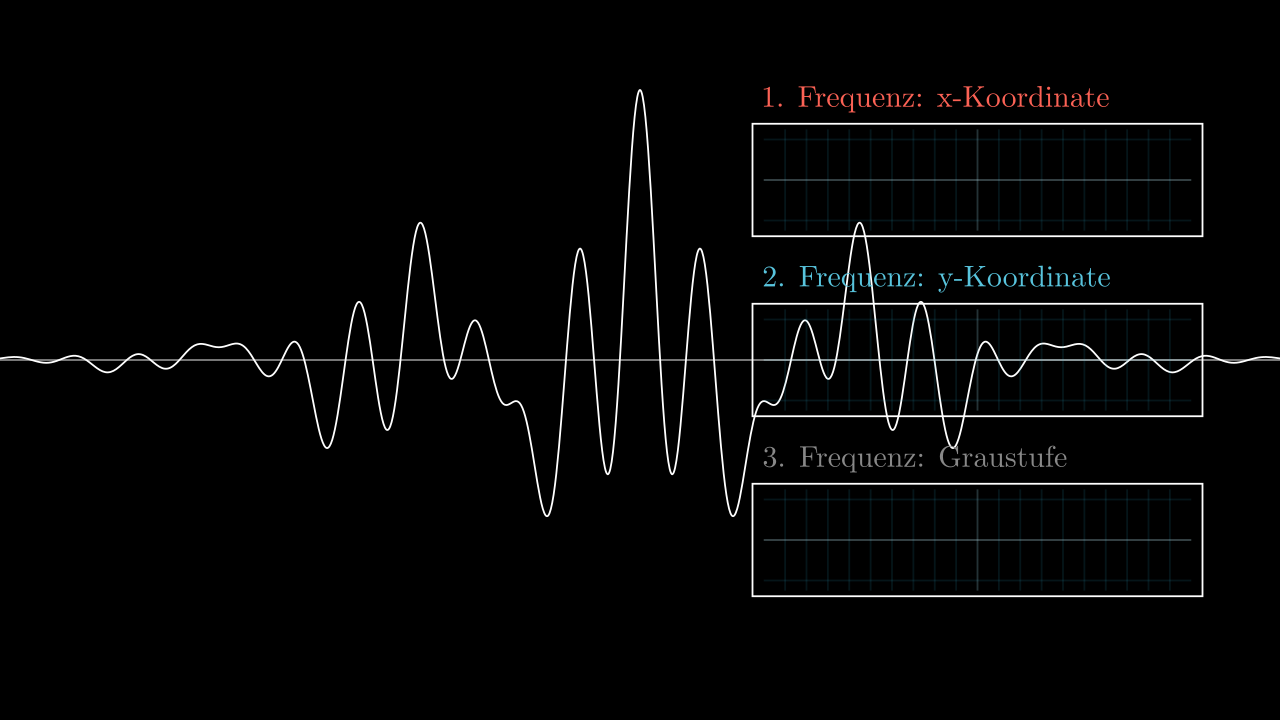

In [228]:
%%capture_video --path "animations/christmas_fourier/christmas_fourier_singlewave.mp4"
%%manim -qm --fps 64 $video_scene


class cf_Scene(Scene):
    def construct(self):

        # initial signal
        init_signal_omega_xyc = encoded_data_list_spiral[0]
        # creating the iter from the signals
        encoded_data_iter = iter(encoded_data_list_spiral)


        # coordinate system for the total initial superposition of waves
        full_signal_box = FullSignal(position = np.array([0, 0, 0]))
        self.add(full_signal_box)

        # initial wave
        full_wave = full_signal_box.get_wave((init_signal_omega_xyc))
        full_wave.iter = encoded_data_iter
        self.add(full_wave)


        split_signal_x_box = SplitSignal(position = np.array([3.75, 2, 0]), height = 1.25, width = 5, description = "1. Frequenz: x-Koordinate", color = RED)
        split_signal_y_box = SplitSignal(position = np.array([3.75, 0, 0]), height = 1.25, width = 5, description = "2. Frequenz: y-Koordinate", color = BLUE)
        split_signal_c_box = SplitSignal(position = np.array([3.75, -2, 0]), height = 1.25, width = 5, description = "3. Frequenz: Graustufe", color = GREY)
        self.add(split_signal_x_box, split_signal_y_box, split_signal_c_box)


        def wave_updater(wave):
            next_signal_omega_xyc = next(wave.iter)
            wave.become(full_signal_box.get_wave(next_signal_omega_xyc))
            



        # self.play(Create(full_wave), run_time = 5)
        # full_wave.add_updater(wave_updater)
        # t_tracker = ValueTracker(0)
        # self.play(t_tracker.animate.set_value(1), rate_func = linear, run_time = 128/8)
        # self.wait(5)

In [162]:
%%capture_video --path "animations/christmas_fourier/christmas_fourier_start.mp4"
%%manim -qh --fps 64 $video_scene


class cf_Scene(Scene):
    def construct(self):
        #self.camera.background_color = WHITE

        # a fake signal alongside the starting signal
        show_signal_omega_xyc = (180, 290, encoded_data_list_spiral[0][2])
        init_signal_omega_xyc = encoded_data_list_spiral[0]

        # square with the transformed image
        image_box = FTransformedImage(position = np.array([3.75, 0.5, 0]), size = 4)

        # square with the untransformed signal 
        signal_box = IncomingSignal(position = (-3.25, 0.5, 0), height = 4, width = 5)
        self.add(signal_box)


        # setting up the signal using the methods of the boxes             
        show_signal = signal_box.get_signal(show_signal_omega_xyc)                                      # the untransformed show signal wave
        show_signal.pixel = image_box.get_pixel(show_signal_omega_xyc)                                  # the first pixel of the recreated image
        show_signal.pixel_arm = image_box.get_pixel_arm(show_signal_omega_xyc)                          # the descriptor on both axes of the first pixel
        show_signal.ft_signal = signal_box.get_ft_signal(show_signal_omega_xyc)                         # the fourier-transformed signal wave

        init_signal = signal_box.get_signal(init_signal_omega_xyc)                                      # the initial untransformed signal wave
        init_signal.iterator = encoded_data_iter                                                        # the iterator of the omega_xyc frequencies
        init_signal.pixel = image_box.get_pixel(init_signal_omega_xyc)                                  # the first pixel of the recreated image
        init_signal.pixel_arm = image_box.get_pixel_arm(init_signal_omega_xyc)                          # the descriptor on both axes of the first pixel
        init_signal.ft_signal = signal_box.get_ft_signal(init_signal_omega_xyc)                         # the fourier-transformed signal wave
        

        self.wait(1.5)
        self.play(Create(show_signal), run_time = 5)
        self.wait(3)
        self.play(Create(show_signal.ft_signal), run_time = 5)
        self.wait(3)
        self.play(FadeIn(image_box), run_time = 3)
        self.wait(1.5)
        self.play(TransformFromCopy(show_signal.ft_signal, show_signal.pixel), FadeIn(show_signal.pixel_arm), run_time = 3)
        self.wait(3)
        self.play(
            FadeTransform(show_signal, init_signal), 
            FadeTransform(show_signal.ft_signal, init_signal.ft_signal), 
            FadeOut(show_signal.pixel), FadeIn(init_signal.pixel), 
            FadeOut(show_signal.pixel_arm), FadeIn(init_signal.pixel_arm), 
            run_time = 3)
        self.wait(3)

Output saved by overwring previous file at animations/christmas_fourier/christmas_fourier_start.mp4.


In [163]:
%%capture_video --path "animations/christmas_fourier/christmas_fourier_main.mp4"
%%manim -qh --fps 64 $video_scene


class cf_Scene(Scene):
    def construct(self):
        #self.camera.background_color = WHITE

        # starting signal
        init_signal_omega_xyc = encoded_data_list_spiral[0]

        # square with the transformed image
        image_box = FTransformedImage(position = np.array([3.75, 0.5, 0]), size = 4)
        self.add(image_box)

        # square with the untransformed signal 
        signal_box = IncomingSignal(position = (-3.25, 0.5, 0), height = 4, width = 5)
        self.add(signal_box)


        # updates an incoming signal to the next one
        def signal_updater(signal):
            # getting the next frequency
            next_signal_omega_xyc = next(signal.iterator)
            # using the next frequency to update the animation and add the pixel
            self.add(image_box.get_pixel(next_signal_omega_xyc))
            signal.pixel_arm.become(image_box.get_pixel_arm(next_signal_omega_xyc))
            signal.ft_signal.become(signal_box.get_ft_signal(next_signal_omega_xyc))
            signal.become(signal_box.get_signal(next_signal_omega_xyc)) 


        # turning the data list into an iterator and creating the first frequency tupel
        encoded_data_iter = iter(encoded_data_list_spiral)

        # setting up the signals using the methods of the boxes             
        init_signal = signal_box.get_signal(init_signal_omega_xyc)                                      # the initial untransformed signal wave
        init_signal.iterator = encoded_data_iter                                                        # the iterator of the omega_xyc frequencies
        init_signal.pixel = image_box.get_pixel(init_signal_omega_xyc)                                  # the first pixel of the recreated image
        init_signal.pixel_arm = image_box.get_pixel_arm(init_signal_omega_xyc)                          # the descriptor on both axes of the first pixel
        init_signal.ft_signal = signal_box.get_ft_signal(init_signal_omega_xyc)                         # the fourier-transformed signal wave
        

        self.add(init_signal, init_signal.pixel, init_signal.pixel_arm, init_signal.ft_signal)
        self.wait(1.5)
        init_signal.add_updater(signal_updater)
        t_tracker = ValueTracker(0)
        self.play(t_tracker.animate.set_value(1), rate_func = linear, run_time = 128*2)
        self.wait(5)

Output saved by overwring previous file at animations/christmas_fourier/christmas_fourier_main.mp4.
